In [2]:
import sys
import os
import pandas as pd
import numpy as np
import pickle
from collections import Counter,defaultdict

from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis,iqr
from scipy import fftpack as fft
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score,f1_score

In [3]:
class Patient():
    def __init__(self,cgm):
        self.cgm = cgm
        
    def preprocess(self):
        #drop rows with 30% of values missing
        #self.cgm=self.cgm.loc[self.cgm.isnull().mean(axis=1)<0.3,:]
        
        #drop last column as it has many missing values for all patients
        self.cgm=self.cgm.iloc[:,:30]
        
        #reset the indices
        self.cgm.reset_index(inplace=True,drop=True)
        
        #interpolate the remaining missing values
        self.cgm.interpolate(method='polynomial',order=5,inplace=True)
        self.cgm.bfill(inplace=True)
        self.cgm.ffill(inplace=True)
        self.cgm=self.cgm.astype('float64')
        
    def fft(self,):
        ndarr = fft.rfft(self.cgm, n=5, axis=1)
        df= pd.DataFrame(data=ndarr)
        df.columns=['fft'+str(i) for i in range(1,df.shape[1]+1)]
        return df
        
    def rolling_mean(self,win,olap):
        df=self.cgm.rolling(window=win,axis=1).apply(np.mean).dropna(axis=1).iloc[:,::olap]
        df.columns=['rm'+str(i) for i in range(1,df.shape[1]+1)]
        return df
    
    def kurtosis(self,win,olap):
        df=self.cgm.rolling(window=win,axis=1).apply(kurtosis).dropna(axis=1).iloc[:,::olap]
        df.columns=['kt'+str(i) for i in range(1,df.shape[1]+1)]
        return df

    def stdev(self,win,olap):
        df=self.cgm.rolling(window=win,axis=1).apply(np.std).dropna(axis=1).iloc[:,::olap]
        df.columns=['st'+str(i) for i in range(1,df.shape[1]+1)]
        return df
    
    def diff(self,win,olap):
        def getdiff(x):
            return x.max()-x[24]
        #df=self.cgm.rolling(window=win,axis=1).apply(lambda x : getdiff(x)).dropna(axis=1).iloc[:,::olap]
        #df.columns=['diff'+str(i) for i in range(1,df.shape[1]+1)]
        df=self.cgm.apply(lambda x : getdiff(x),axis=1)
        df.name="diff"
        return df
    
#     def vel(self,win,olap):
#         def getvel(x):
# #             x=pd.Series(x)
#             x.reset_index(drop=True,inplace=True)
# #             if abs(int(x[x==x.max()].index[0])-int(x[x==x.min()].index[0])):
# #                 return abs(x.max()-x.min())/abs(int(x[x==x.max()].index[0])-int(x[x==x.min()].index[0]))
            
#             if abs(int(x[x==x.max()].index[0])-24):
#                 return abs(x.max()-24)/abs(int(x[x==x.max()].index[0])-24)

#             return 0

# #         df=self.cgm.rolling(window=win,axis=1).apply(lambda x : getvel(x)).dropna(axis=1).iloc[:,::olap]
# #         df.columns=['vel'+str(i) for i in range(1,df.shape[1]+1)]
#         df=self.cgm.apply(lambda x: getvel(x),axis=1)
#         df.name="vel"
#         return df
    
#     def kurt(self):
#         df=self.cgm.apply(kurtosis,axis=1)
#         df.name='ktw'
#         return df
    
#     def iqrg(self):
#         df=self.cgm.apply(iqr,axis=1)
#         df.name='iqr'
#         return df

#     def tdiff(self):
#         def gettdiff(x):
#             x.reset_index(drop=True,inplace=True)
#             return (x.max()-x.min())/abs(x[x==x.max()].index[0]-x[x==x.min()].index[0])
#         df=self.cgm.apply(lambda x: gettdiff(x),axis=1)
#         df.name='tdiff'
#         return df
    
    def featureMatrix(self):
        self.preprocess()
        #self.stdev(10,5),self.kurtosis(10,5)
        df=pd.concat([self.fft(),self.rolling_mean(10,5),self.stdev(10,5),self.kurtosis(10,5),self.diff(10,5)],axis=1)
        return df

In [4]:
cnames=["cgmSeries_ 1","cgmSeries_ 2","cgmSeries_ 3","cgmSeries_ 4","cgmSeries_ 5","cgmSeries_ 6","cgmSeries_ 7","cgmSeries_ 8","cgmSeries_ 9","cgmSeries_10","cgmSeries_11","cgmSeries_12","cgmSeries_13","cgmSeries_14","cgmSeries_15","cgmSeries_16","cgmSeries_17","cgmSeries_18","cgmSeries_19","cgmSeries_20","cgmSeries_21","cgmSeries_22","cgmSeries_23","cgmSeries_24","cgmSeries_25","cgmSeries_26","cgmSeries_27","cgmSeries_28","cgmSeries_29","cgmSeries_30","cgmSeries_31"
]

In [5]:
p1m=Patient(pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealData1.csv',names=cnames,nrows=50))

p2m=Patient(pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealData2.csv',names=cnames,nrows=50))

p3m=Patient(pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealData3.csv',names=cnames,nrows=50))

p4m=Patient(pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealData4.csv',names=cnames,nrows=50))

p5m=Patient(pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealData5.csv',names=cnames,nrows=50))

In [6]:
p1m=p1m.featureMatrix()

p2m=p2m.featureMatrix()

p3m=p3m.featureMatrix()

p4m=p4m.featureMatrix()

p5m=p5m.featureMatrix()

C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
C:\Users\hp\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

In [7]:
print(p1m.shape)
p1m.head()

(50, 21)


,fft1,fft2,fft3,fft4,fft5,rm1,rm2,rm3,rm4,rm5,...,st2,st3,st4,st5,kt1,kt2,kt3,kt4,kt5,diff
0,1182.0,-23.163119,14.714876,-15.336881,3.836982,246.4,274.9,300.2,293.6,257.4,...,20.559426,9.568699,19.090312,26.695318,-0.208756,-1.515119,-0.328795,1.445918,-1.607184,67.0
1,355.0,-18.881966,30.968593,-21.118034,7.310693,96.0,147.0,183.0,177.2,150.0,...,30.315013,16.649324,18.513779,13.667480,-1.317493,-1.161329,-0.752697,-1.103917,-1.093657,58.0
2,1053.0,2.572949,-8.196237,5.927051,-3.751226,205.2,192.1,147.5,94.7,80.6,...,14.425325,41.855107,22.441257,2.537716,-1.188582,0.305964,-1.355264,-0.268141,-0.350141,135.0
3,1114.0,-2.708204,-13.037277,10.708204,-0.171513,208.7,175.9,139.8,130.0,144.1,...,22.451949,20.798077,8.497058,7.555792,-1.482744,-0.679630,-1.295945,-1.433906,-0.895771,85.0
4,891.0,13.927051,-9.735079,10.572949,-3.387954,173.5,165.3,153.1,126.6,103.9,...,3.769615,10.681292,19.432962,7.020684,0.270900,-1.602060,-0.599807,-1.509356,0.260080,88.0


In [8]:
l1=pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealAmountData1.csv',nrows=50,names=['Labels'])
l2=pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealAmountData2.csv',names=['Labels'],nrows=50)
l3=pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealAmountData3.csv',names=['Labels'],nrows=50)
l4=pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealAmountData4.csv',names=['Labels'],nrows=50)
l5=pd.read_csv(os.path.abspath('')+'\MealNoMealData\mealAmountData5.csv',names=['Labels'],nrows=50)

In [9]:
l1.head()

,Labels
0,45
1,65
2,60
3,80
4,45


In [10]:
p1m.shape

(50, 21)

In [11]:
p1m=pd.concat([p1m,l1],axis=1)
p2m=pd.concat([p2m,l2],axis=1)
p3m=pd.concat([p3m,l3],axis=1)
p4m=pd.concat([p4m,l4],axis=1)
p5m=pd.concat([p5m,l5],axis=1)

In [12]:
p1m.shape

(50, 22)

In [13]:
p1m.tail()

,fft1,fft2,fft3,fft4,fft5,rm1,rm2,rm3,rm4,rm5,...,st3,st4,st5,kt1,kt2,kt3,kt4,kt5,diff,Labels
45,897.0,23.972136,-22.184571,15.027864,-4.510524,174.4,171.0,165.0,153.1,149.0,...,10.705139,8.141867,1.183216,0.443249,-0.995868,-1.285455,1.575933,-1.061224,45.0,85
46,1237.0,-22.045085,30.017537,-16.454915,6.722908,258.6,253.3,198.7,146.9,128.5,...,43.255173,21.961102,5.389805,-0.842592,-0.659905,-1.455132,0.842063,-1.501175,147.0,0
47,1356.0,4.454915,-14.714876,10.045085,-3.836982,262.6,236.9,194.1,172.8,172.4,...,27.980172,8.634813,5.986652,-1.166360,-1.207263,-1.537480,-1.119278,-1.058332,102.0,80
48,938.0,-3.809017,4.392011,-2.690983,1.400084,188.6,187.6,182.6,188.2,201.0,...,3.878144,12.440257,10.751744,-0.535894,-1.516017,-0.977578,-0.706433,-0.756462,0.0,26
49,1133.0,-13.281153,-3.665469,-3.218847,1.677599,216.9,192.7,149.1,110.7,100.7,...,32.503692,14.339107,1.552417,-1.359551,-0.651084,-1.446673,0.360066,-1.494224,129.0,100


In [14]:
def makebins(x):
    if x==0:
        return 1
    elif x<21:
        return 2
    elif x<41:
        return 3
    elif x<61:
        return 4
    elif x<81:
        return 5
    else:
        return 6

In [15]:
p1m['Labels']=p1m['Labels'].apply(lambda x: makebins(x))
p2m['Labels']=p2m['Labels'].apply(lambda x: makebins(x))
p3m['Labels']=p3m['Labels'].apply(lambda x: makebins(x))
p4m['Labels']=p4m['Labels'].apply(lambda x: makebins(x))
p5m['Labels']=p5m['Labels'].apply(lambda x: makebins(x))

In [16]:
p1m.head()

,fft1,fft2,fft3,fft4,fft5,rm1,rm2,rm3,rm4,rm5,...,st3,st4,st5,kt1,kt2,kt3,kt4,kt5,diff,Labels
0,1182.0,-23.163119,14.714876,-15.336881,3.836982,246.4,274.9,300.2,293.6,257.4,...,9.568699,19.090312,26.695318,-0.208756,-1.515119,-0.328795,1.445918,-1.607184,67.0,4
1,355.0,-18.881966,30.968593,-21.118034,7.310693,96.0,147.0,183.0,177.2,150.0,...,16.649324,18.513779,13.667480,-1.317493,-1.161329,-0.752697,-1.103917,-1.093657,58.0,5
2,1053.0,2.572949,-8.196237,5.927051,-3.751226,205.2,192.1,147.5,94.7,80.6,...,41.855107,22.441257,2.537716,-1.188582,0.305964,-1.355264,-0.268141,-0.350141,135.0,4
3,1114.0,-2.708204,-13.037277,10.708204,-0.171513,208.7,175.9,139.8,130.0,144.1,...,20.798077,8.497058,7.555792,-1.482744,-0.679630,-1.295945,-1.433906,-0.895771,85.0,5
4,891.0,13.927051,-9.735079,10.572949,-3.387954,173.5,165.3,153.1,126.6,103.9,...,10.681292,19.432962,7.020684,0.270900,-1.602060,-0.599807,-1.509356,0.260080,88.0,4


In [17]:
data=pd.concat([p1m,p2m,p3m,p4m,p5m],ignore_index=True)

In [18]:
stdscaler = StandardScaler()
data1 = stdscaler.fit_transform(data.iloc[:,:21])

data1=pd.DataFrame(data1)
mat=data1.iloc[:,:20]
p = PCA(n_components=5)

mat = pd.DataFrame(p.fit_transform(mat))

filename = open('pca.pkl','wb')
pickle.dump(p,filename)
filename.close()

mat=pd.concat([mat,data1.iloc[:,20:],data.iloc[:,21:]],axis=1)

In [19]:
print(mat.shape)
mat.head()

(250, 7)


,0,1,2,3,4,20,Labels
0,-2.596664,1.409419,-0.487706,0.938026,0.453629,-0.112592,4
1,0.292790,-1.821094,-1.054424,0.071115,1.657199,-0.254470,5
2,0.926676,-0.129005,0.085467,-1.483709,-1.566627,0.959373,4
3,0.696909,-0.005653,0.364728,-1.047234,-0.441089,0.171163,5
4,0.865396,-1.172680,1.111605,-0.667290,-0.125585,0.218456,4


In [20]:
train,test=train_test_split(mat,random_state=2,train_size=200)
print(train.shape,test.shape)

(200, 7) (50, 7)


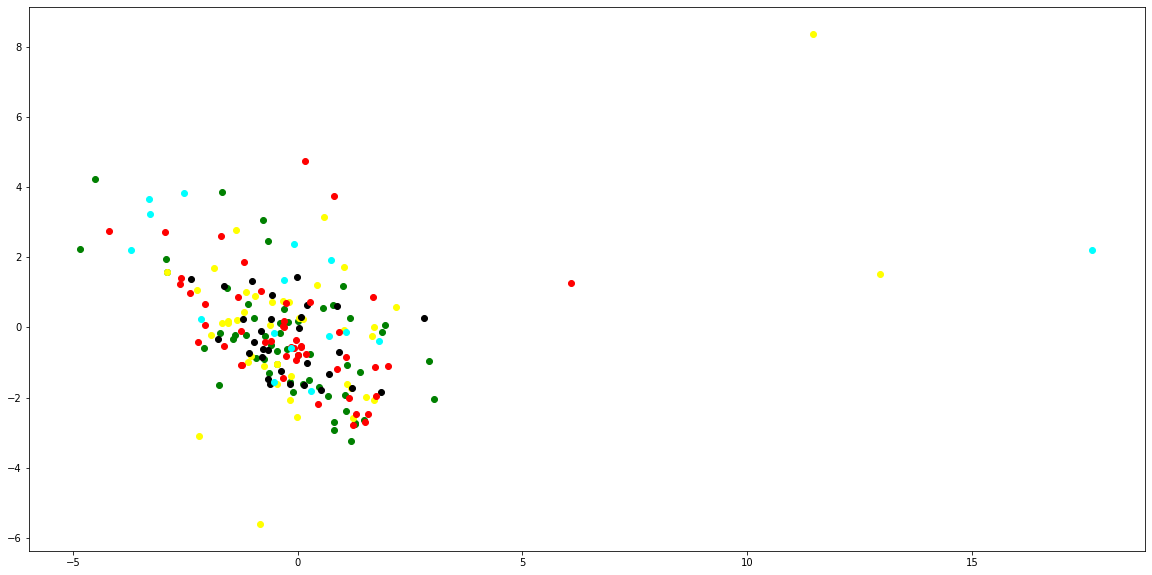

In [21]:
plt.figure(figsize=(20,10))
colors=['blue','green','yellow','black','red','cyan']


for i in range(6):
    #c=train[train['Labels']==i].shape[0]
    plt.scatter(train[train['Labels']==i][0],train[train['Labels']==i][1],color=colors[i])
    #plt.scatter(train[train['Labels']==i][0],[0]*c,color=colors[i])

In [22]:
def getMajority(pred,ground):
    majority = defaultdict(list)
    for i in range(1,len(set(pred))+1):
        cluster=list(train.iloc[pred[:,]==i,6])
        majority[i]=cluster

    new={}
    for (key, value) in majority.items(): 
        tot = len(value)
        l = Counter(majority[key]).most_common()
        a = {}
        for x in l:
            a[x[0]] = x[1]/tot
        new[key] = a
    new = pd.DataFrame(new).fillna(0)
    new_maj = {}
    cols = list(new.columns)
    rows= list(new.index.values)
    tups = new[cols].sort_values(cols, ascending=False).apply(tuple, 1)
    f, i = pd.factorize(tups)
    factorized = pd.Series(f + 1, tups.index)
    new['Rank']=new.assign(Rank=factorized)['Rank']  
    idx = list(new['Rank'])
    
    for i in range(len(cols)):
        new_maj[cols[i]] = rows[idx[i]-1]
    return new_maj

In [23]:
kmeans=KMeans(n_clusters=6)
pred=kmeans.fit_predict(train.iloc[:,:6])+1
new_maj = getMajority(pred,train.iloc[:,6])
new_kmean = [new_maj[c] for c in pred]

print("Accuracy:",accuracy_score(train.iloc[:,6],new_kmean))
f1_kmean = f1_score(train.iloc[:,6], new_kmean, average='macro')
print("F1 Score:",f1_kmean)

Accuracy: 0.175
F1 Score: 0.13845937019279994


In [24]:
preds=DBSCAN(eps=1.26,min_samples=2).fit_predict(train.iloc[:,:6])
print(preds)

[ 0  0  1  0 -1  0  0 -1  0 -1  0 -1  0  0 -1  0  0  0  0  0  2  0  2 -1
  0  0  0  3  0  2  0  0  0  0  0  0  0  2  0  0  0  0  0 -1 -1  0 -1  0
  0  0  0  0 -1  0  0 -1  0  0 -1  0  0  0  0  0  0 -1  0  0 -1 -1 -1 -1
  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1 -1  4  0  0  0 -1
 -1  0 -1  0 -1  0 -1  0 -1 -1  0 -1  0  0  0  0  0  0  0  0  0 -1  3  0
 -1  0  0  0  0  0 -1  5  0 -1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1  4  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0 -1 -1 -1  0  0
  5  0 -1  0  0  0  2  0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  0  5  0
 -1  0 -1  0  0  0  4  5]


In [25]:
def getlabel(x,train):
    if x['preds']==-1:
        ferr,mil=sys.maxsize,-1
        for i in range(1,7):
            centroid=np.mean(train[train['preds']==i].iloc[:,:6],0)
            err=np.linalg.norm(x[:6]-centroid,ord=2)
            err=np.sum(err)
            if ferr>err:
                ferr=err
                mil=i
        x['preds']=int(mil)
    return x

In [26]:
preds=[x if x<5 else -1 for x in preds]
train.reset_index(inplace=True,drop=True)
preds=pd.DataFrame(preds,columns=['preds'])

preds=pd.concat([train,preds],axis=1)

preds=preds.apply(lambda x: getlabel(x,preds[preds['preds']!=-1]),axis=1)
preds.head()

,0,1,2,3,4,20,Labels,preds
0,-2.896509,1.569123,-0.073408,1.362363,1.156298,-0.648575,1.0,0.0
1,0.798418,-2.683363,0.303765,1.106561,-0.659219,-0.853510,1.0,0.0
2,0.784823,0.635528,1.104543,0.257135,-0.466005,0.533740,1.0,1.0
3,-1.921916,-0.221654,-0.905356,-0.299728,-0.076597,-0.002243,2.0,0.0
4,-0.146116,-0.546740,-0.755595,1.417084,-0.124937,0.092342,4.0,1.0


In [27]:
dbscan_maj = getMajority(np.asarray(preds['preds']),np.asarray(preds['Labels']))
new_dbscan = [dbscan_maj[c+1] for c in preds['preds']]

print("Accuracy:",accuracy_score(preds.iloc[:,6],new_dbscan))
f1_kmean = f1_score(preds.iloc[:,6], new_dbscan, average='macro')
print("F1 Score:",f1_kmean)

Accuracy: 0.255
F1 Score: 0.1554334554334554


C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
export = np.column_stack((preds.iloc[:,:6], new_kmean,new_dbscan)) 
np.savetxt("clusters.csv", export, delimiter=",",fmt='%f')